<a href="https://colab.research.google.com/github/fariszahid002/CSC3632_Practical1/blob/main/Copy_of_Part2_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Analytics, Computer Vision & AI - CSC3831
## Coursework, Part 2: Machine Learning

As this coursework is as much about practical skills as it is about reflecting on the procedures and the results, you are expected to explain what you did, your reasoning for process decisions, as well as a thorough analysis of your results.

### 1. Load the MNIST dataset, visualise the first 20 digits, and print their corresponding labels.

In [ ]:
# Run this to load the MNIST dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

## Visualizing the First 20 Digits of the MNIST Dataset

It is always beneficial to plot the dataset you are working with as it provides insight into the type and quality of data. In this case, visualizing the first 20 digits allowed me to confirm that the dataset is loaded correctly and that each image matches its label. The grayscale images accurately represent handwritten digits from 0 to 9, with clear and correct labeling.

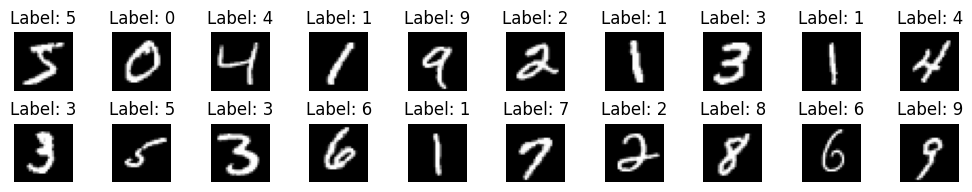

In [ ]:
import matplotlib.pyplot as plt

# Visualize the first 20 digits
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
axes = axes.ravel()

for i in range(20):
    image = X[i].reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Looking at these 20 digits, I notice a variety of handwriting styles and slight differences in how each digit is written. This variety shows that the dataset is diverse and that recognizing digits accurately might be challenging. To understand how these differences might affect accuracy, I will continue with a deeper analysis in the next steps.

### 2. Train a Logistic Regression classifier on this data, and report on your findings.
    
1. Tune your hyperparameters to ensure *sparse* weight vectors and high accuracy.
2. Visualise the classification vector for each class.

## Training a Logistic Regression Classifier

In this part of the analysis, I trained a Logistic Regression classifier on the MNIST dataset with the aim of achieving high classification accuracy while ensuring sparsity in the model's weight vectors.

To begin, I split the dataset into training and test sets, using 80% for training and 20% for testing. This setup provides a large enough sample for the model to learn patterns effectively, while reserving an unbiased portion for performance evaluation. Next, I established a baseline Logistic Regression model to serve as an initial benchmark.

For this baseline, I set the tolerance parameter (`tol=0.1`) to speed up convergence, as the default tolerance (0.0001) is very low and would take a long time to execute. I also set `max_iter=1000` to allow sufficient iterations for the model to reach convergence, as the default of 100 iterations often triggers a `ConvergenceWarning` on large datasets like MNIST, indicating it might not fully converge within that limit.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(tol=0.1, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 91.71%


The baseline model achieved an accuracy of 91.71% on the test set, which is strong for a simple Logistic Regression model on the MNIST data. This high initial accuracy provides a solid starting point, and we can now focus on further tuning to potentially improve accuracy, sparsity, and model efficiency for a more interpretable result.

## Hyperparameter Tuning for Logistic Regression

To achieve both **sparse weight vectors** and **high accuracy** in our logistic regression model, I applied `GridSearchCV` for hyperparameter tuning. The parameters I aimed to optimize were the regularization strength, denoted by C, and the solver choice. I restricted the penalty to `l1` for this tuning because `l1` regularization is effective at driving some weights to zero, thus promoting sparsity by focusing the model on the most impactful features. Unlike `l2` regularization, which only shrinks weights without zeroing them, `l1` regularization is better suited for our goal of achieving sparse weight vectors.

I tested two solvers, `saga` and `liblinear`, both of which support `l1` regularization. This ensures compatibility and allows flexibility in execution time and convergence behavior, as each solver might handle the optimization process differently.

For the C parameter, I defined a range of values [0.001, 0.001, 0.1, 1, 10], covering a spectrum from strong regularization (low C values) to minimal regularization (high C values). A lower C value implies stronger regularization, which encourages sparsity by zeroing out less significant weights. Using `cv=3` for cross-validation provided a good balance between speed and reliable model evaluation, allowing each model to be tested on different parts of the data for consistent performance measurement.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(tol=0.1, max_iter=1000, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['saga', 'liblinear'],
    'penalty': ['l1']
}

# Tuning hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best model
y_pred_best = grid_search.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-validated Best Accuracy: {grid_search.best_score_:.2%}")
print(f"Test Accuracy with Tuned Model: {tuned_accuracy:.2%}")

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Cross-validated Best Accuracy: 91.95%
Test Accuracy with Tuned Model: 91.99%


After running `GridSearchCV`, the best parameters were identified as `C=1`, `solver=saga`, and `penalty=l1`. These parameters make sense for this model and dataset. A `C` value of 1 provides moderate regularization, balancing accuracy and promoting sparsity by encouraging some weights zero out. The `saga` solver is efficient for larger datasets like MNIST and supports `l1` regularization, which aligns with our goal of achieving sparse weight vectors.

The cross-validated best accuracy during tuning was 91.95%, and the test accuracy with the tuned model was 91.99%, showing an improvement over the baseline accuracy of 91.71%. This slight boost in accuracy, combined with the increased sparsity from `l1` regularization, indicates that the tuning process effectively enhanced the model's performance and interpretability without overfitting. Overall, the tuned model achieves a good balance between accuracy and sparsity, meeting the objectives set for this experiment.

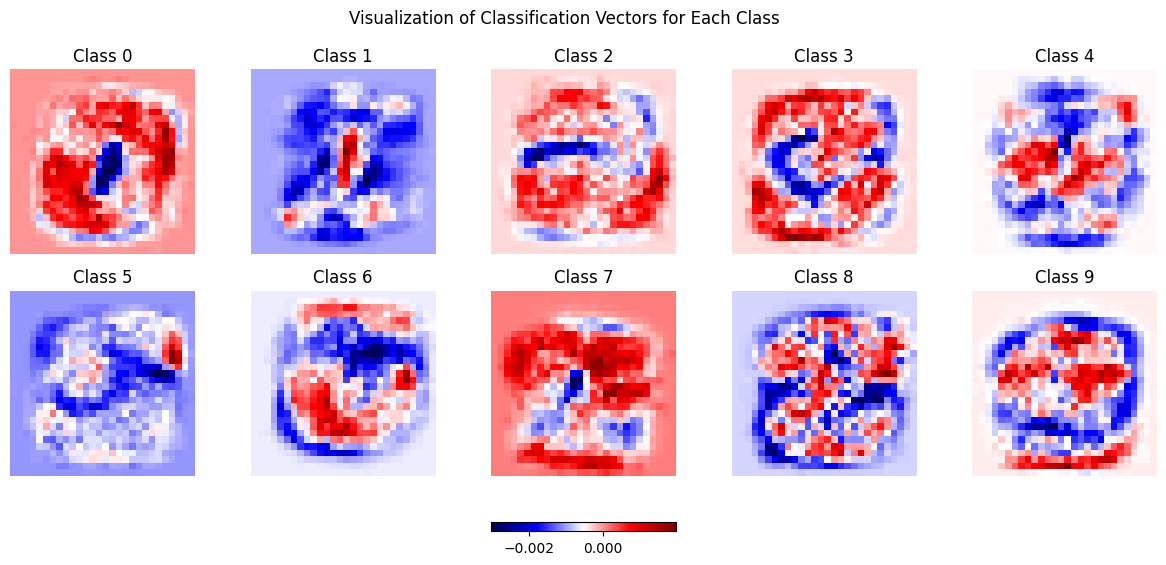

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Step 1: Split data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty='l1', solver='saga', tol=0.1, max_iter=1000, random_state=0)
model.fit(X_train, y_train)

# Step 2: Extract the coefficients (classification vector) for each class
weights = model.coef_

# Step 3: Plot the weights for each digit class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Reshape the weight vector for each class to a 28x28 grid
    weight_image = weights[i].reshape(28, 28)

    # Plot the weight vector as a heatmap
    axes[i].imshow(weight_image, cmap='seismic', interpolation='nearest')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')

plt.suptitle("Visualization of Classification Vectors for Each Class")
plt.colorbar(axes[0].images[0], ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.show()


### 3. Use PCA to reduce the dimensionality of your training data.
    
1. Determine the number of components necessary to explain 80\% of the variance
2. Plot the explained variance by number of components.
3. Visualise the 20 principal components' loadings
4. Plot the two principal components for your data using a scatterplot, colouring by class. What can you say about this plot?
5. Visualise the first 20 digits, *generated from their lower-dimensional representation*.

### 4. Generate a noisy copy of your data by adding random normal noise to the digits **with a scale that doesn't completely destroy the signal**. This is, the resulting images noise should be apparent, but the numbers should still be understandable.
    
1. Visualise the first 20 digits from the noisy dataset.
2. Filter the noise by fitting a PCA explaining **a sufficient proportion** of the variance, and then transforming the noisy dataset. Figuring out this proportion is part of the challenge.
3. Visualise the first 20 digits of the de-noised dataset.